# Do all analysis and plots

In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr

In [2]:
os.makedirs('../plots', exist_ok=True)

In [3]:
pl.style.use('../defaults.mplstyle')

In [4]:
# no CH4 removal, i.e. fair default runs, with no temperature rebasing
noch4r = xr.open_dataset('../results/noCH4R_cal-1.4.0.nc')

In [5]:
# CH4 removal runs with temperature rebasing
ch4r = xr.open_dataset('../results/CH4R_cal-1.4.0.nc')

In [6]:
# CH4 lifetime in the default case
noch4r_lifetime = xr.open_dataset('../results/noCH4R_lifetime_cal-1.4.0.nc')

## These are raw outputs for the first ssp119 ensemble member in 2010 and should not differ.

In [7]:
noch4r.temperature.sel(timebound=2010, scenario='ssp119', config=1439, layer=0).data[()]

0.8285165636168961

In [8]:
ch4r.temperature.sel(timebound=2010, scenario='ssp119', config=1439).data[()]

0.8285165636168961

In [9]:
temp_norm_20032022 = np.ones(21)
temp_norm_20032022[0] = 0.5
temp_norm_20032022[-1] = 0.5

In [10]:
np.average(noch4r.temperature.sel(timebound=np.arange(2003, 2024), scenario='ssp119', config=1439, layer=0), weights=temp_norm_20032022)

0.9417972596704001

In [11]:
np.average(ch4r.temperature.sel(timebound=np.arange(2003, 2024), scenario='ssp119', config=1439), weights=temp_norm_20032022)

0.9417972596704001

In [12]:
ecs_tcr = pd.read_csv('../results/ecs_tcr_cal-1.4.0.csv', index_col=0)

In [13]:
colors = {
    'ssp119': '#00a9cf',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': '#707070', #'#B8BDAA',
    'ssp534-over': '#92397a'
}

In [14]:
scenarios = ['ssp119', 'COFFEE1.1 EN_NPi2020_400f_lowBECCS', 'ssp534-over']
labels = {
    'ssp119': 'SSP1-1.9',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': 'IMP-Neg',
    'ssp534-over': 'SSP5-3.4-OS'
}

In [15]:
def powerfit(x, a, b, c):
    return a + b * x**c

def squarerootfit(x, b):
    return 1.5 + b * x**0.5

In [16]:
quantiles = [.05, .25, .50, .75, .95]
mod = {}
res_all = {}
x_p = {}
df_p = {}
p = {}
cov = {}
exceeds = {}

modsr = {}
res_allsr = {}
x_psr = {}
df_psr = {}
psr = {}
covsr = {}


for iscen, scenario in enumerate(scenarios):
    over1p5 = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )
    ) >= 1.5
    x = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5]/1000
    )
    y = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5]
    )
    exceeds[scenario] = (
        np.max(
            ch4r.temperature.loc[
                dict(scenario=scenario)
            ] - np.average(
                ch4r.temperature.loc[
                    dict(scenario=scenario, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data > 1.5
    )
    xe = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5 & ~exceeds[scenario]]/1000
    )
    ye = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5 & ~exceeds[scenario]]
    )
    
    d = {'peak': ye, 'ch4': xe}
    dsr = {'peak': ye, 'ch4': xe}
    df = pd.DataFrame(data=d)
    
    # scipy curve_fit
    p[scenario], cov[scenario] = curve_fit(powerfit, xe, ye)
    psr[scenario], covsr[scenario] = curve_fit(squarerootfit, xe, ye)
    
    # use the best estimate of the exponent from this to feed into the quantile regression
    
    # statsmodels fit
    mod[scenario] = smf.quantreg(f'peak ~  I(ch4 ** {p[scenario][2]})', df)
    modsr[scenario] = smf.quantreg(f'peak ~ I(ch4 ** 0.5)', df)
    
    # get all result instances in a list
    res_all[scenario] = [mod[scenario].fit(q=q) for q in quantiles]
    x_p[scenario] = np.linspace(0, x.max(), 100)
    df_p[scenario] = pd.DataFrame({'ch4': x_p})

    res_allsr[scenario] = [modsr[scenario].fit(q=q) for q in quantiles]
    x_psr[scenario] = np.linspace(0, x.max(), 100)
    df_psr[scenario] = pd.DataFrame({'ch4': x_psr})

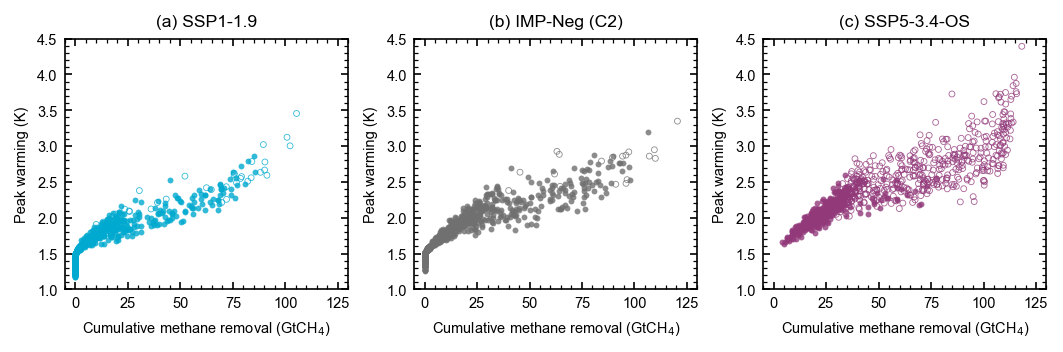

In [17]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
#     for qm, res in zip(quantiles, res_all[scenario]):
#         q[qm] = res.predict({'peak': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
#     ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
#     ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (K)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 4.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_cal-1.4.0.pdf')

## gigatons removal required in ssp119 to avoid peak 1.5C

In [18]:
np.percentile(-np.sum(
    ch4r.emissions.loc[
        dict(scenario='ssp119')
    ] - noch4r.emissions.loc[
        dict(scenario='ssp119', specie='CH4')
    ], axis=0
)[~exceeds['ssp119']]/1000, (5, 50, 95, 100))

array([ 0.   ,  2.08 , 55.323, 85.44 ])

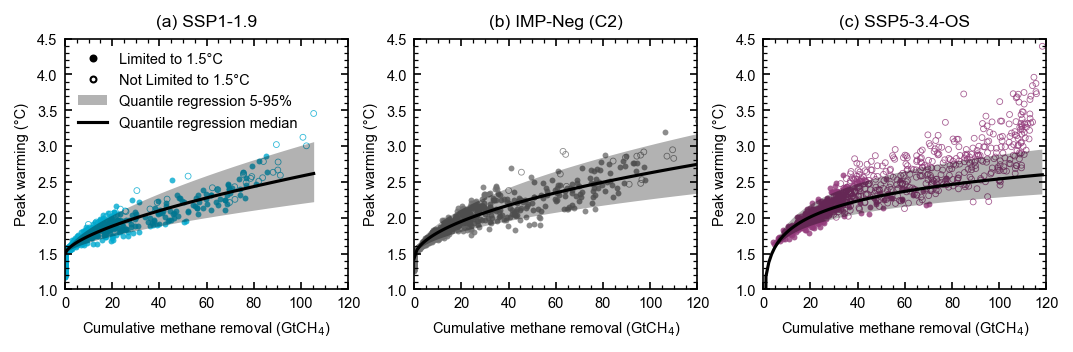

In [19]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_all[scenario]):
        q[qm] = res.predict({'ch4': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
    #ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    #ax[iscen].plot(x_p[scenario], q[.5], color='k')
    ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (°C)')
    ax[iscen].set_xlim(0, 120)
    ax[iscen].set_ylim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Not Limited to 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Quantile regression median'),
]
ax[0].legend(handles=legend_elements, loc='upper left', frameon=False)

fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_quant_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_quant_cal-1-4-0.pdf')

In [20]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_all[scenario][qidx].params)
        print()

ssp119 0.05
Intercept                       1.497292
I(ch4 ** 0.6436868200646482)    0.036275
dtype: float64

ssp119 0.5
Intercept                       1.498101
I(ch4 ** 0.6436868200646482)    0.055854
dtype: float64

ssp119 0.95
Intercept                       1.505556
I(ch4 ** 0.6436868200646482)    0.077714
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept                       1.465442
I(ch4 ** 0.5206282704173888)    0.072554
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept                       1.431614
I(ch4 ** 0.5206282704173888)    0.108713
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept                       1.445081
I(ch4 ** 0.5206282704173888)    0.143182
dtype: float64

ssp534-over 0.05
Intercept                        -2.603735
I(ch4 ** 0.052799093140026954)    3.831745
dtype: float64

ssp534-over 0.5
Intercept                        -3.973654
I(ch4 ** 0.052799093140026954)    5.109175
dtype: float64

ssp534-over 0.95
Inte

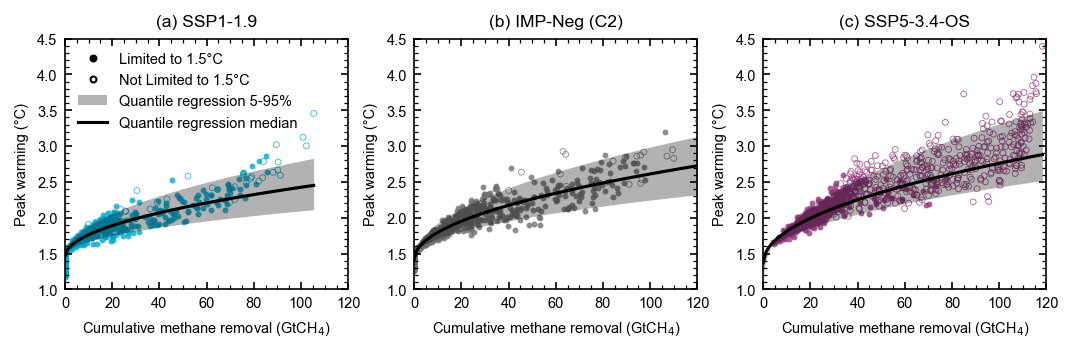

In [21]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_allsr[scenario]):
        q[qm] = res.predict({'ch4': x_psr[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
    ax[iscen].fill_between(x_psr[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_psr[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (°C)')
    ax[iscen].set_xlim(0, 120)
    ax[iscen].set_ylim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Not Limited to 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Quantile regression median'),
]
ax[0].legend(handles=legend_elements, loc='upper left', frameon=False)

fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_quantsquarerootfit_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_quantsquarerootfit_cal-1-4-0.pdf')

In [22]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_allsr[scenario][qidx].params)
        print()

ssp119 0.05
Intercept        1.473947
I(ch4 ** 0.5)    0.062213
dtype: float64

ssp119 0.5
Intercept        1.455399
I(ch4 ** 0.5)    0.097039
dtype: float64

ssp119 0.95
Intercept        1.468345
I(ch4 ** 0.5)    0.132637
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept        1.457467
I(ch4 ** 0.5)    0.078885
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept        1.416966
I(ch4 ** 0.5)    0.119460
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept        1.433919
I(ch4 ** 0.5)    0.155240
dtype: float64

ssp534-over 0.05
Intercept        1.401878
I(ch4 ** 0.5)    0.102713
dtype: float64

ssp534-over 0.5
Intercept        1.371571
I(ch4 ** 0.5)    0.138873
dtype: float64

ssp534-over 0.95
Intercept        1.200548
I(ch4 ** 0.5)    0.211158
dtype: float64



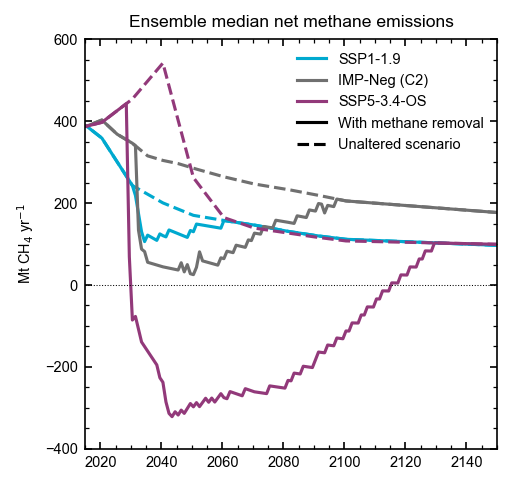

In [23]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
    
hands, labs = ax.get_legend_handles_labels()

hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')

ax.set_xlim(2015, 2150)
ax.set_ylim(-400, 600)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median net methane emissions');
pl.savefig('../plots/netCH4emissions_cal-1.4.0.png')
pl.savefig('../plots/netCH4emissions_cal-1.4.0.pdf')

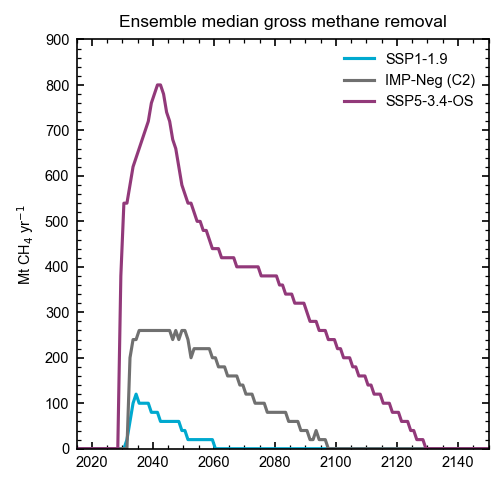

In [24]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax.set_xlim(2015, 2150)
ax.set_ylim(0, 900)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(frameon=False)
ax.set_title('Ensemble median gross methane removal');
pl.savefig('../plots/grossCH4removal_cal-1.4.0.png')
pl.savefig('../plots/grossCH4removal_cal-1.4.0.pdf')

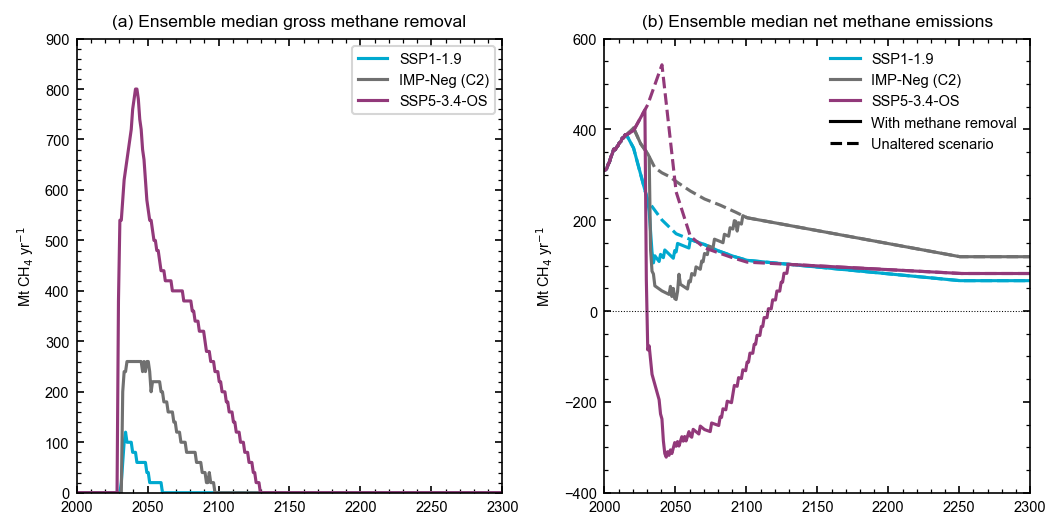

In [25]:
fig, ax = pl.subplots(1, 2, figsize=(18/2.54, 9/2.54))
for scenario in scenarios:
    ax[1].plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax[1].plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-400, 600)
ax[1].axhline(0, lw=0.5, ls=':', color='k')
ax[1].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[1].set_title('(b) Ensemble median net methane emissions');

hands, labs = ax[1].get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[1].legend(hands, labs, frameon=False)

for scenario in scenarios:
    ax[0].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0, 900)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[0].legend()
ax[0].set_title('(a) Ensemble median gross methane removal');
fig.tight_layout()

pl.savefig('../plots/netCH4emissions_grossCH4removal_cal-1.4.0.png')
pl.savefig('../plots/netCH4emissions_grossCH4removal_cal-1.4.0.pdf')

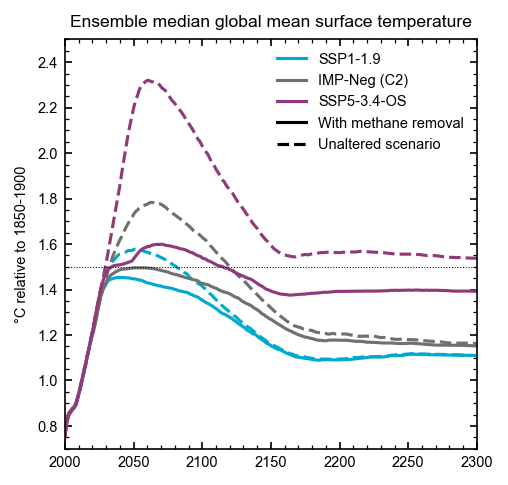

In [26]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(
            (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ), axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0.7, 2.5)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('°C relative to 1850-1900')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median global mean surface temperature');
pl.savefig('../plots/temperature-cal_1.4.0.png')
pl.savefig('../plots/temperature-cal_1.4.0.pdf')

In [27]:
np.median(
    (
        noch4r.temperature.loc[dict(scenario='ssp119', layer=0)] -
        np.average(noch4r.temperature.loc[dict(scenario='ssp119', layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
        + 1.03
    ),
    axis=1
).max()

1.5773214963966844

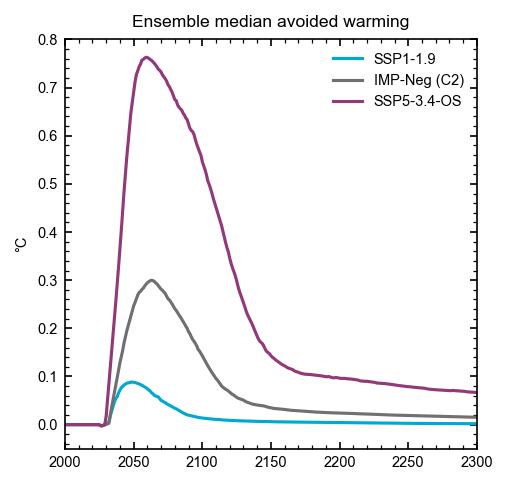

In [28]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax.set_xlim(2000, 2300)
ax.set_ylim(-0.05, 0.8)
ax.set_ylabel('°C')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(frameon=False)
ax.set_title('Ensemble median avoided warming');
pl.savefig('../plots/avoidedwarming_cal-1.4.0.png')
pl.savefig('../plots/avoidedwarming_cal-1.4.0.pdf')

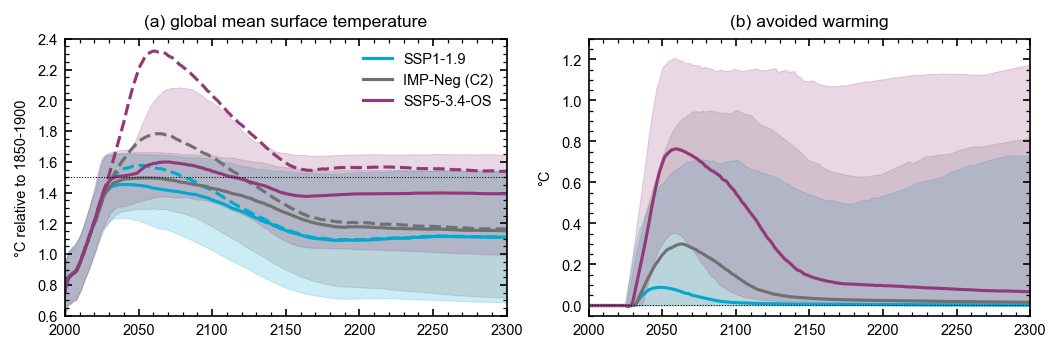

In [29]:
fig, ax = pl.subplots(1, 2, figsize=(18/2.54, 6/2.54))
for scenario in scenarios:
    ax[0].fill_between(
        ch4r.timebound, 
        np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, 5, axis=1), 
        np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, 95, axis=1), 
        color=colors[scenario],
        lw=0.5,
        alpha=0.2,
    );
    ax[0].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        ls='--',
    );
    ax[0].plot(
        ch4r.timebound, 
        np.median(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax[0].get_legend_handles_labels()
# hands.append(Line2D([0], [0], color='k', lw=1.5))
# hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
# labs.append('With methane removal')
# labs.append('Unaltered scenario')
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0.6, 2.4)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('°C relative to 1850-1900')
ax[0].axhline(1.5, lw=0.5, ls=':', color='k')
ax[0].legend(hands, labs, frameon=False)
ax[0].set_title('(a) global mean surface temperature');

for scenario in scenarios:
    ax[1].fill_between(
        ch4r.timebound, 
        np.percentile(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            5,
            axis=1
        ),
        np.percentile(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            95,
            axis=1
        ),
        color=colors[scenario],
        lw=0.5,
        alpha=0.2,
    );
    ax[1].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-0.05, 1.3)
ax[1].set_ylabel('°C')
ax[1].axhline(0, lw=0.5, ls=':', color='k')
#ax[1].legend(frameon=False)
ax[1].set_title('(b) avoided warming');

fig.tight_layout()
pl.savefig('../plots/temperature-cal_1.4.0.png')
pl.savefig('../plots/temperature-cal_1.4.0.pdf')

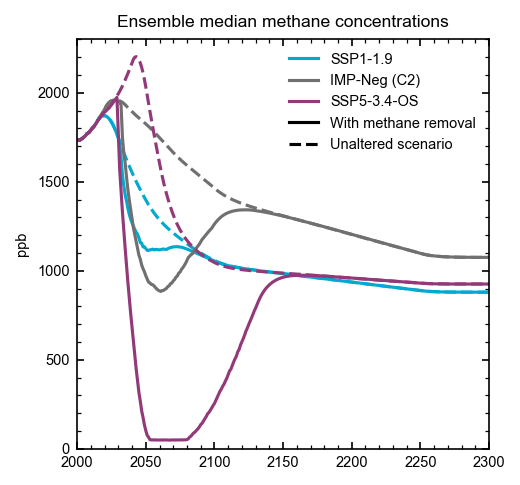

In [30]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.concentration.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.concentration.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0, 2300)
ax.set_ylabel('ppb')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane concentrations');
pl.savefig('../plots/CH4concentrations_cal-1.4.0.png')
pl.savefig('../plots/CH4concentrations_cal-1.4.0.pdf')

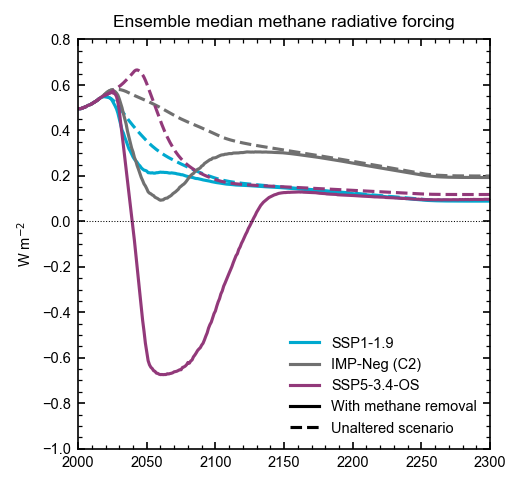

In [31]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_ch4.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_xlim(2000, 2300)
ax.set_ylim(-1, 0.8)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('W m$^{-2}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane radiative forcing');
pl.savefig('../plots/CH4forcing_cal-1.4.0.png')
pl.savefig('../plots/CH4forcing_cal-1.4.0.pdf')

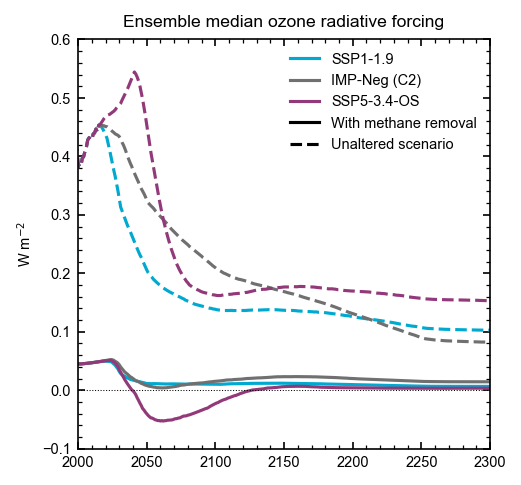

In [32]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='Ozone')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_o3.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(-0.1, 0.6)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median ozone radiative forcing');
pl.savefig('../plots/O3forcing_cal-1.4.0.png')
pl.savefig('../plots/O3forcing_cal-1.4.0.pdf')

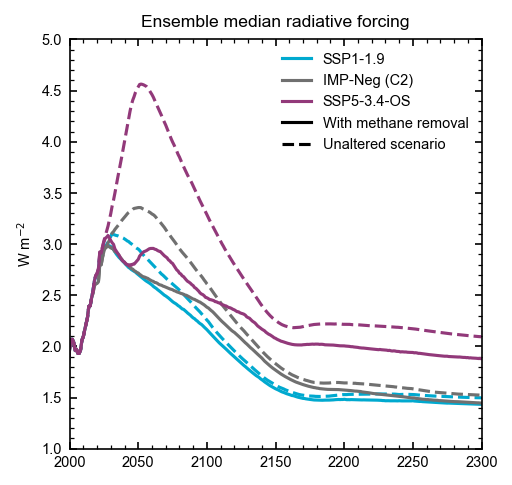

In [33]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        ls = '--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(1, 5)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median radiative forcing');
pl.savefig('../plots/totalforcing_cal-1.4.0.png')
pl.savefig('../plots/totalforcing_cal-1.4.0.pdf')

In [34]:
noch4r_lifetime.loc[dict(scenario=scenario)]

<xarray.Dataset>
Dimensions:                        (config: 841, timebounds: 551)
Coordinates:
  * config                         (config) int32 1439 2367 ... 1595502 1597514
  * timebounds                     (timebounds) float64 1.75e+03 ... 2.3e+03
    scenario                       <U11 'ssp534-over'
    specie                         object ...
Data variables:
    __xarray_dataarray_variable__  (timebounds, config) float64 ...

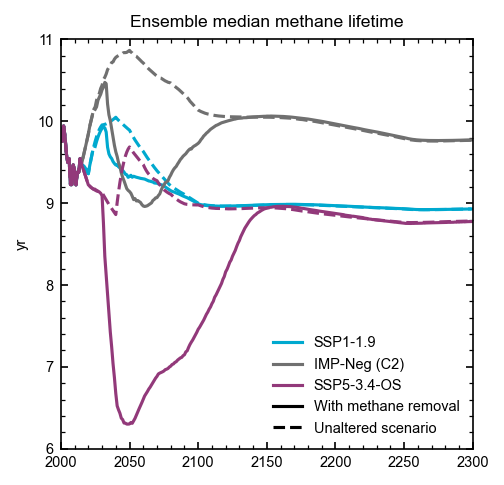

In [35]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r_lifetime.loc[dict(scenario=scenario)].__xarray_dataarray_variable__, axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.lifetime.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(6, 11)
ax.set_ylabel('yr')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane lifetime');
pl.savefig('../plots/CH4lifetime_cal-1.4.0.png')
pl.savefig('../plots/CH4lifetime_cal-1.4.0.pdf')

In [36]:
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')].shape

(550, 841)

In [37]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

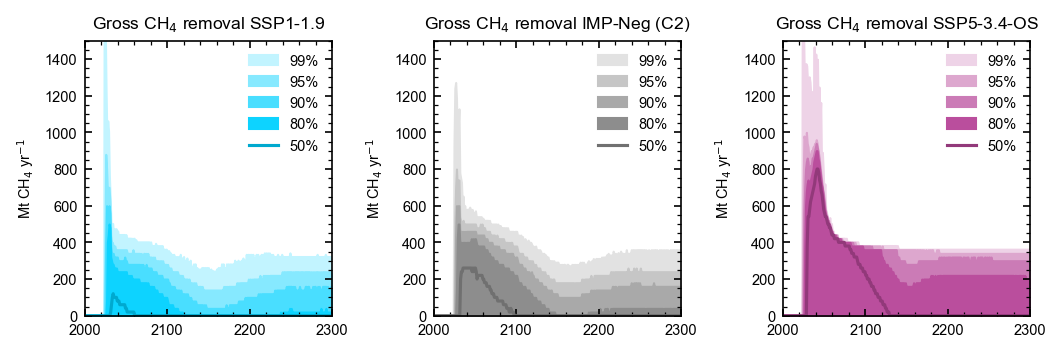

In [38]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):

    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            99,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.2),
        label='99%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            95,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.4),
        label='95%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            90,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.6),
        label='90%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            80,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.8),
        label='80%',
    );
    
    ax[iscen].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), 
        color=colors[scenario],
        label='50%',
    );
    ax[iscen].set_xlim(2000, 2300)
    ax[iscen].set_ylim(0,1500)
    #ax.set_ylim(0, 900)
    ax[iscen].set_ylabel('Mt CH$_4$ yr$^{-1}$')
    ax[iscen].legend(frameon=False)
    ax[iscen].set_title(f'Gross CH$_4$ removal {labels[scenario]}');
fig.tight_layout()
pl.savefig('../plots/grossCH4removalpercentiles_cal-1.4.0.png')
pl.savefig('../plots/grossCH4removalpercentiles_cal-1.4.0.pdf')

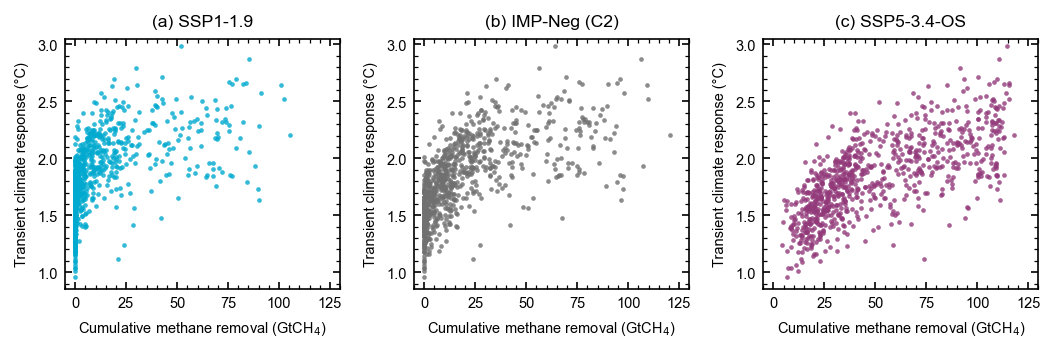

In [39]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        ecs_tcr["TCR"],
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Transient climate response (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(0.85, 3.05)
fig.tight_layout()
pl.savefig('../plots/cumCH4_TCR_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_TCR_cal-1.4.0.pdf')

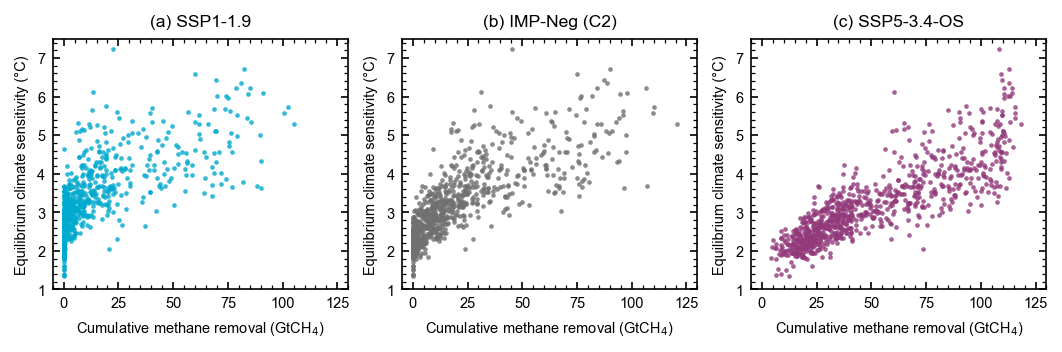

In [40]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        ecs_tcr["ECS"],
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Equilibrium climate sensitivity (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 7.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_ECS_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_ECS_cal-1.4.0.pdf')

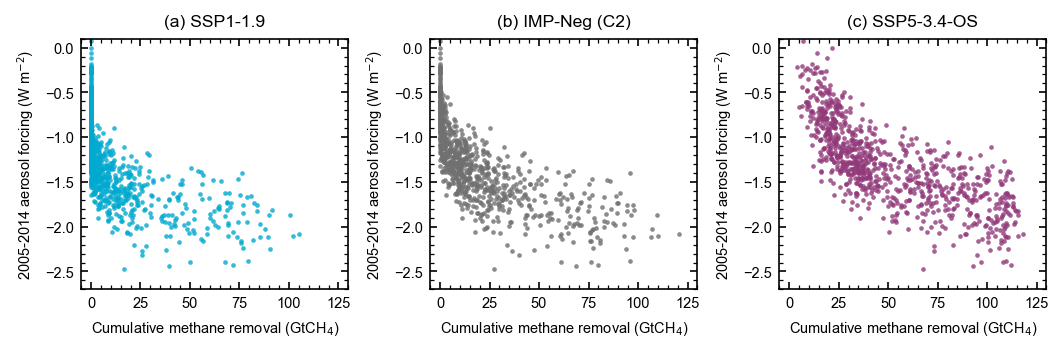

In [41]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        noch4r.forcing.loc[
            dict(scenario=scenario, specie='Aerosol-radiation interactions', timebound=np.arange(2005, 2015))
        ].mean(dim='timebound')+noch4r.forcing.loc[
            dict(scenario=scenario, specie='Aerosol-cloud interactions', timebound=np.arange(2005, 2015))
        ].mean(dim='timebound'),
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('2005-2014 aerosol forcing (W m$^{-2}$)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-2.7, 0.1)
fig.tight_layout()
pl.savefig('../plots/cumCH4_aerosolF_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_aerosolF_cal-1.4.0.pdf')

In [42]:
zec = pd.read_csv('../results/zec_esm-bell_cal-1.4.0.csv', index_col=0)
zec

,zec48_750,zec50_750,zec100_750,zec50_1000,zec100_1000
1439,-0.002759,-0.003022,-0.005765,0.012883,0.026147
2367,-0.026719,-0.027645,-0.039258,-0.018993,-0.018031
2658,-0.052683,-0.054219,-0.084428,-0.060431,-0.089159
2806,-0.020562,-0.020310,-0.010691,-0.014467,0.012470
5770,-0.036261,-0.036643,-0.043602,-0.039270,-0.040049
...,...,...,...,...,...
1592481,0.079153,0.082740,0.159201,0.127308,0.243549
1593875,0.035302,0.037260,0.081332,0.060538,0.133058
1595217,-0.136338,-0.139932,-0.211806,-0.176056,-0.266346
1595502,-0.001863,-0.001342,0.007957,0.005752,0.026922


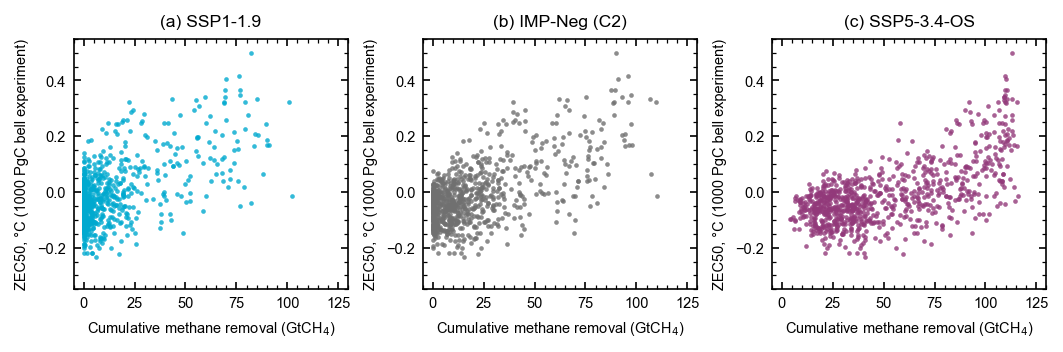

In [43]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        zec.zec50_1000,
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('ZEC50, °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.35, 0.55)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')   
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec50_1000_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_zec50_1000_cal-1.4.0.pdf')

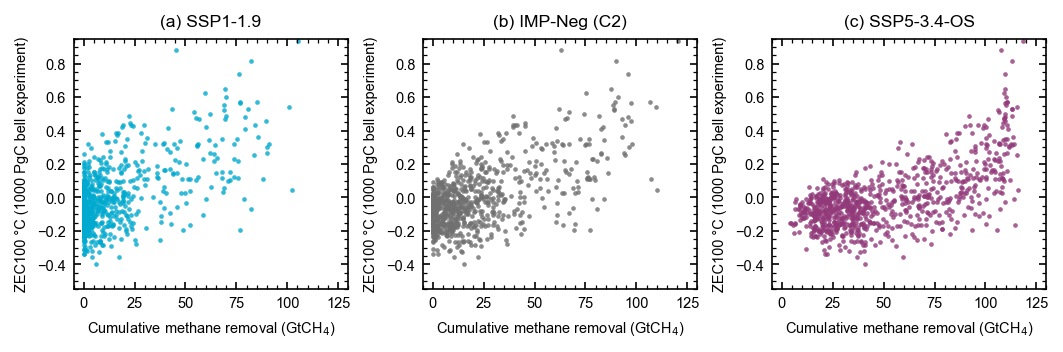

In [44]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        zec.zec100_1000,
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('ZEC100 °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.55, 0.95)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec100_1000_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_zec100_1000_cal-1.4.0.pdf')

In [45]:
ch4_obs = pd.read_csv('../data/constraints/IGCC_methane_concentrations_1750-2022.csv', index_col=0)
gmst_obs = pd.read_csv('../data/constraints/IGCC_GMST_1850-2022.csv', index_col=0)

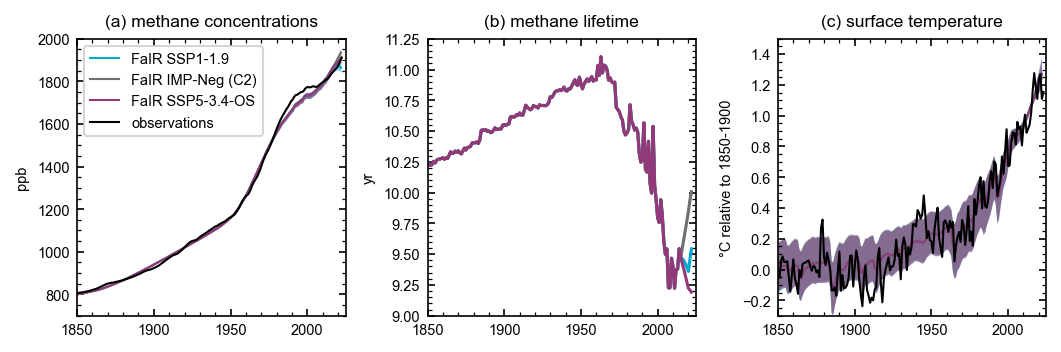

In [46]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for scenario in scenarios:
    ax[0].fill_between(
        np.arange(1750, 2023), 
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).min(dim='config'),
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).max(dim='config'),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    );
    ax[0].plot(
        np.arange(1750, 2023), 
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).median(dim='config'),
        color=colors[scenario],
        lw=1,
        label=f'FaIR {labels[scenario]}',
    );
ax[0].plot(ch4_obs.index+0.5, ch4_obs, color='k', lw=1, label='observations')
ax[0].legend()
ax[0].set_xlim(1850, 2025);
ax[0].set_ylim(700, 2000);
ax[0].set_ylabel('ppb')
ax[0].set_title('(a) methane concentrations')

for scenario in scenarios:
    ax[1].plot(
        np.arange(1750, 2023), 
        ch4r.lifetime.sel(scenario=scenario, timebound=np.arange(1750, 2023)).median(dim='config'), color=colors[scenario],
    );
ax[1].set_xlim(1850, 2025);
ax[1].set_ylim(9, 11.25);
ax[1].set_ylabel('yr')
ax[1].set_title('(b) methane lifetime')

for scenario in scenarios:
    ax[2].fill_between(
        np.arange(1750, 2023), 
        (
            ch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023))
          - np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
          + 1.03
        ).quantile(0.05, dim='config'),
        (
            ch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023))
          - np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
          + 1.03
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    );
    ax[2].plot(
        np.arange(1750, 2023), 
        (
            noch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023), layer=0) -
            np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
            + 1.03
        ).median(dim='config'),
        color=colors[scenario],
        lw=1,
        label=f'FaIR {labels[scenario]}',
    );
ax[2].plot(gmst_obs.index+0.5, gmst_obs, color='k', lw=1)
ax[2].set_xlim(1850, 2025);
ax[2].set_ylim(-0.3, 1.5);
ax[2].set_ylabel('°C relative to 1850-1900')
ax[2].set_title('(c) surface temperature')

fig.tight_layout()
pl.savefig('../plots/historical_cal-1.4.0.png')
pl.savefig('../plots/historical_cal-1.4.0.pdf')

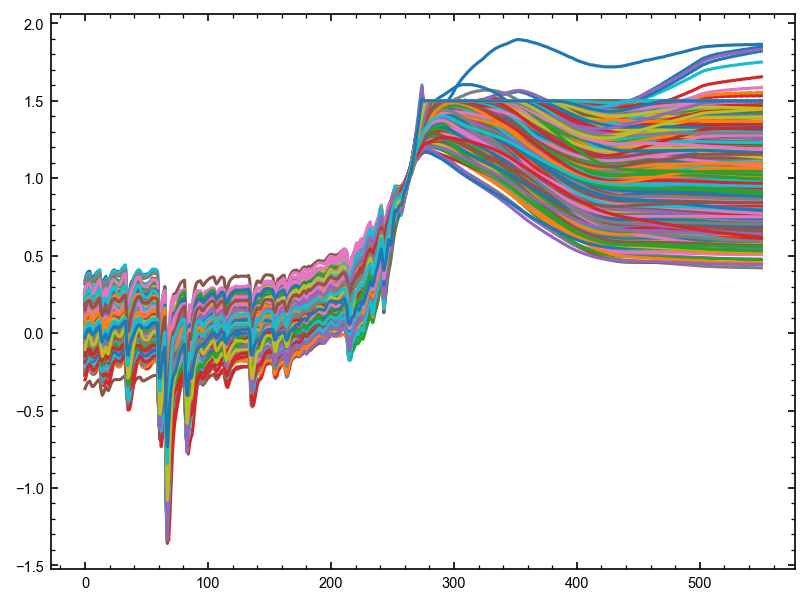

In [47]:
pl.plot(1.03 + ch4r.temperature[:, 0, :] - np.average(ch4r.temperature[253:274, 0, :].data, weights=temp_norm_20032022, axis=0));

In [48]:
np.average(ch4r.temperature[253:274, 0, :].data, weights=temp_norm_20032022, axis=0)#.mean(axis=0)

array([0.94179726, 1.11525163, 0.90124375, 0.93573918, 1.16665078,
       0.93662621, 0.84868072, 0.94131803, 0.91958345, 1.13215391,
       0.9546875 , 1.03655021, 0.98360209, 0.99633298, 0.99495731,
       1.08802561, 0.84233099, 0.93593688, 1.18722   , 1.10954914,
       0.83340184, 1.22101826, 0.95814135, 0.97745203, 0.82830811,
       1.19795285, 1.08869329, 1.00911758, 1.05929473, 0.92979278,
       1.0678139 , 0.8093257 , 1.08970355, 0.96462297, 1.16242893,
       1.00580438, 1.17830321, 1.09496953, 0.97112777, 1.12632558,
       1.07055461, 1.07516799, 0.91902052, 1.09213549, 1.03712815,
       0.96447892, 1.12056873, 1.01142423, 0.85256378, 1.13484088,
       0.94591461, 0.913168  , 0.94449641, 0.95432452, 1.06836199,
       1.12514231, 0.90814817, 1.06630945, 0.93735077, 1.01053887,
       1.15691453, 1.14682004, 0.74561236, 0.88328482, 0.93995042,
       0.97860159, 1.09146109, 1.11112318, 0.96565729, 1.08029599,
       1.19582569, 1.143925  , 1.23810208, 1.12909223, 1.15981

In [49]:
np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)

array([0.94247744, 1.11802907, 0.9001822 , 0.93993006, 1.17124529,
       0.93616078, 0.85389419, 0.94415545, 0.92499216, 1.13506199,
       0.95354835, 1.04057219, 0.98481378, 1.00114642, 0.99369413,
       1.08460212, 0.83415137, 0.92501711, 1.19093579, 1.10255438,
       0.8321562 , 1.2165055 , 0.95617474, 0.97790484, 0.82458601,
       1.20276675, 1.09595569, 1.01255316, 1.06096397, 0.92315537,
       1.07229526, 0.80626278, 1.09678675, 0.95195343, 1.16472911,
       1.00913528, 1.17981136, 1.09808427, 0.97192383, 1.13269841,
       1.0629303 , 1.07289117, 0.92134384, 1.09711919, 1.04041651,
       0.9650315 , 1.12147959, 1.01385523, 0.84657469, 1.14089642,
       0.94636031, 0.90645631, 0.94755028, 0.95800272, 1.06726257,
       1.1267209 , 0.89812064, 1.06459555, 0.93138514, 1.0152543 ,
       1.16160832, 1.14947698, 0.74560487, 0.87523091, 0.94125861,
       0.98080051, 1.07845142, 1.11715246, 0.96104469, 1.08504794,
       1.19887004, 1.14674969, 1.24448327, 1.13469631, 1.16615

## Calculate effective cumulative removal

[Abernethy et al. 2021](https://royalsocietypublishing.org/doi/10.1098/rsta.2021.0104)

$E(t) = \int_0^t R(t') e^{-t'/\tau} dt'$

In [112]:
scenario='ssp119'

In [113]:
# R(t')
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)]

<xarray.DataArray 'emissions' (timepoint: 550, config: 841)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [40.,  0.,  0., ...,  0.,  0., 40.],
       [40.,  0.,  0., ...,  0.,  0., 60.],
       [60.,  0.,  0., ...,  0.,  0., 40.]])
Coordinates:
  * config     (config) int32 1439 2367 2658 2806 ... 1595217 1595502 1597514
  * timepoint  (timepoint) float64 1.75e+03 1.752e+03 ... 2.298e+03 2.3e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'

In [114]:
# tau
ch4r.lifetime.loc[dict(scenario=scenario)]

<xarray.DataArray 'lifetime' (timebound: 551, config: 841)>
[463391 values with dtype=float64]
Coordinates:
  * config     (config) int32 1439 2367 2658 2806 ... 1595217 1595502 1597514
  * timebound  (timebound) int32 1750 1751 1752 1753 ... 2297 2298 2299 2300
    scenario   <U6 'ssp119'

In [115]:
# first R(t') where we see any action. This is 2024 to 2025, so could be the cumulative R at 2025.01.01
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=2024.5)] - ch4r.emissions.loc[dict(scenario=scenario, timepoint=2024.5)]

<xarray.DataArray 'emissions' (config: 841)>
array([   0.,  800.,    0.,    0.,    0., 1760.,    0.,    0.,    0.,
          0., 3420.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., 5120.,    0.,    0.,    0.,  660.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  320.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  280.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        380., 1600.,    0.,    0., 1160.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
...
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., 1860.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2860.,    0.,  880.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,   40.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  100.,
        340.,    0.,    0.,    0.,    0.,  140.,    0.,    0.,  820.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., 2340.,    0.,   80.,    0.,    0.,  260.,
          0.,    0.,  820.,    0.,    0., 4580., 1500.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0., 1740.,    0.,    0.,
          0.,    0., 3240.,    0.,  920.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0., 3060.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., 1920.])
Coordinates:
  * config     (config) int32 1439 2367 2658 2806 ... 1595217 1595502 1597514
    timepoint  float64 2.024e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'

In [116]:
ch4r.lifetime.loc[dict(scenario=scenario, timebound=2025)]

<xarray.DataArray 'lifetime' (config: 841)>
[841 values with dtype=float64]
Coordinates:
  * config     (config) int32 1439 2367 2658 2806 ... 1595217 1595502 1597514
    timebound  int32 2025
    scenario   <U6 'ssp119'

In [117]:
# first R(t') where we see any action. This is 2024 to 2025, so could be the cumulative R at 2025.01.01
(
    noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=2024.5)] - 
    ch4r.emissions.loc[dict(scenario=scenario, timepoint=2024.5)]
) / np.exp(-1 / ch4r.lifetime.loc[dict(scenario=scenario, timebound=2025)])

<xarray.DataArray (config: 841)>
array([   0.        ,  887.8987975 ,    0.        ,    0.        ,
          0.        , 1951.35017744,    0.        ,    0.        ,
          0.        ,    0.        , 3793.33905384,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       5675.91278823,    0.        ,    0.        ,    0.        ,
        731.25708568,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  354.3928428 ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  310.77929421,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
...
        288.4754003 ,    0.        ,    0.        ,  910.44025186,
          0.        ,    0.        , 5084.91044575, 1664.84531883,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        , 1932.46879183,    0.        ,
          0.        ,    0.        ,    0.        , 3598.91144613,
          0.        , 1020.69012764,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        , 3396.20998571,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       2130.57548751])
Coordinates:
  * config     (config) int32 1439 2367 2658 2806 ... 1595217 1595502 1597514
    timepoint  float64 2.024e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'
    timebound  int32 2025

In [118]:
# do a numerical integration
equivalent_marginal_removal = np.zeros((278, 841))
for itb, timebound in enumerate(range(2023, 2301)):
    equivalent_marginal_removal[itb, :] = (
        noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=timebound-0.5)] - 
        ch4r.emissions.loc[dict(scenario=scenario, timepoint=timebound-0.5)]
    ) / np.exp(-1 / ch4r.lifetime.loc[dict(scenario=scenario, timebound=timebound)])

In [119]:
equivalent_cumulative_removal = np.nancumsum(equivalent_marginal_removal, axis=0)

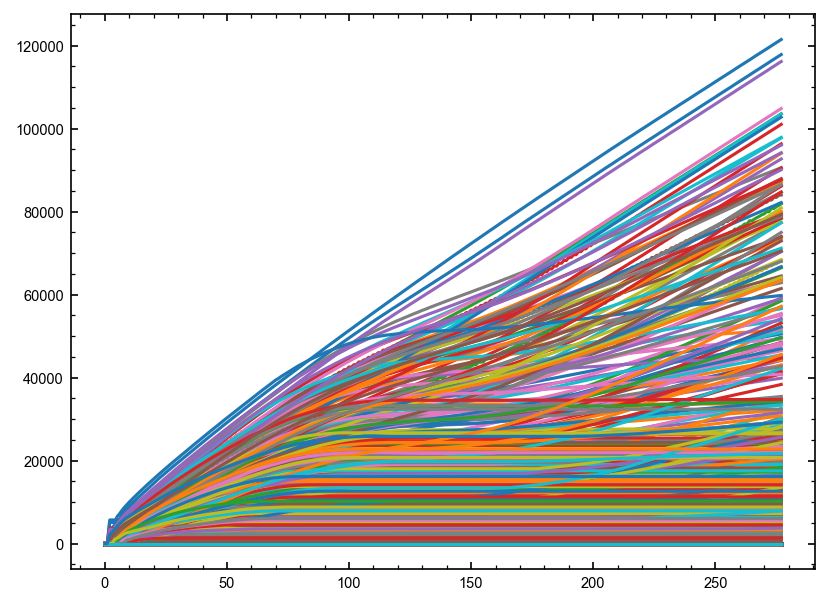

In [120]:
pl.plot(equivalent_cumulative_removal);

In [121]:
delta_T = (
    noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
    np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    + 1.03
) - (
    ch4r.temperature.loc[dict(scenario=scenario)] -
    np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    + 1.03
)[273:, :]

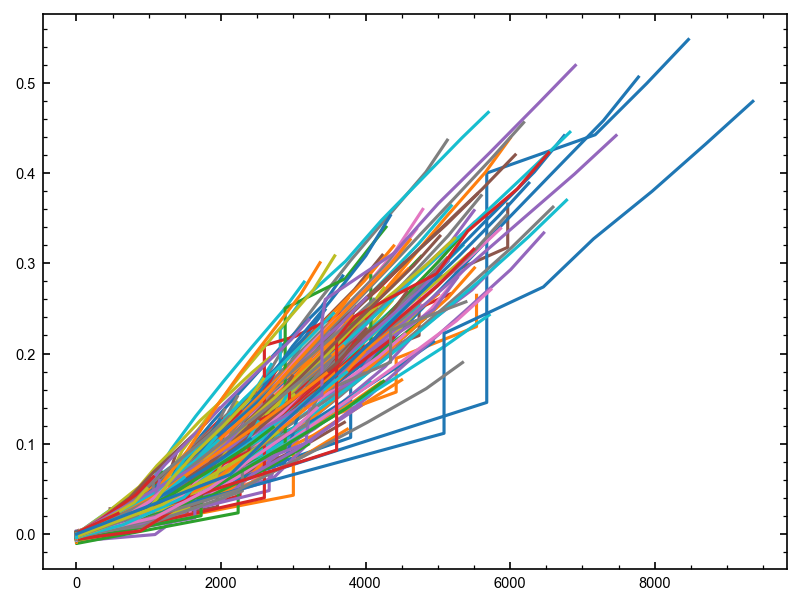

In [124]:
pl.plot(equivalent_cumulative_removal[:10, :], delta_T[:10, :]);